In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

In [ ]:
img1 = cv2.imread('box.png')  
img2 = cv2.imread('box_in_scene.png')

img1 adalah barangnya secara direct

img2 adalah barang yang berada di dalam suatu scene

In [ ]:
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)  
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

gambarnya kita ubah ke grayscale terlebih dahulu

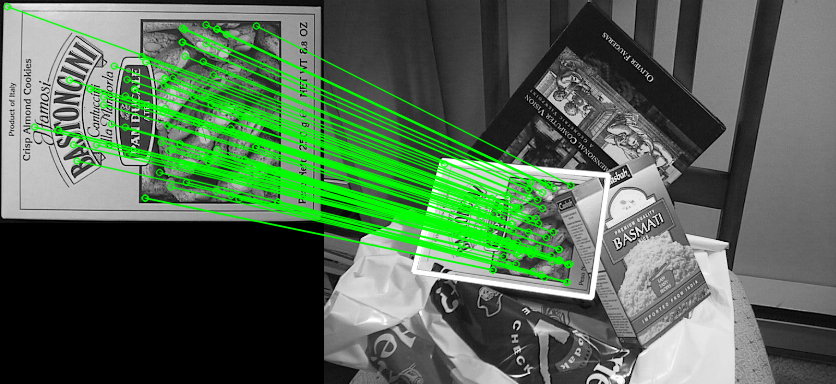

In [ ]:
#saya membuat SIFT terlebih dahulu lalu mencari keypoints dan descriptor dari setiap gambar
detector = cv2.SIFT_create()
keypoints1, descriptors1 = detector.detectAndCompute(img1, None)
keypoints2, descriptors2 = detector.detectAndCompute(img2, None)

#Lalu saya membuat FLANN
FLANN = cv2.FlannBasedMatcher(dict(algorithm = 1, trees = 5), dict(checks = 50))

#Lalu mencari yang matching dengan KNN biar lebih cepat
matches = FLANN.knnMatch(descriptors1, descriptors2, k = 2)

#jika distance antar descriptor tidak terlalu jauh,
#kita dapat anggap itu adalah pasangan yang benar 
#oleh karena itu kita mengambil yang masuk ke dalam ratio saja
ratio_thresh = 0.8
good_matches = []
for m,n in matches:
    if m.distance < ratio_thresh * n.distance:
        good_matches.append(m)

#lalu matrixnya saya transform bagi yang ada di dalam good_matches
src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

#Lalu saya mencari homograpghy dari gambarnya menggunakan ransac
M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
matchesMask = mask.ravel().tolist()

#lalu saya membuat line untuk objeknya yang berada di scene sesuai dengan
#original object yang ada di gambar lain
h, w = img1.shape
pts = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2)
dst = cv2.perspectiveTransform(pts, M)
item = cv2.polylines(img2, [np.int32(dst)], True, 255, 3, cv2.LINE_AA)

draw_params = dict(
    matchColor = (0, 255, 0),
    singlePointColor = None,
    matchesMask = matchesMask,
    flags = 2
)  

target = cv2.drawMatches(img1, keypoints1, img2, keypoints2, good_matches, None, **draw_params)


cv2_imshow(target)